# Intro to Pattern Recognition
# Problem Set 4: Neural Networks
### M S Mohamed Fazil
### UB Id : mm549

## Introduction
We will be using neural networks to build a model that classifies hand written digits using thr MNIST database. The MNIST database (Modified National Institute of Standards and Technology Database) is a large collection of handwritten digits which happens to be a state of the art data set to train and test machine learning models using image processing.It consist of 60000 Training samples and 10000 Testing Samples. Each sample image consist of normalized $28X28$ pixels grayscale image stored as 784 dimensional vector for each sample.This is a way of dimension reduction done by the MNIST to use it for model developments.

### Libraries Used
For loading the given MNIST datasets we will be using the mnist library to fetch the data.The MNIST() function will be used to fetch the datasets from the directory './data'. For the purpose of building neural networks and trainning we will be using Keras library which is backed by the Tensorflow. We will use OpenCv for the image processing applications.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import to_categorical
from keras import optimizers,regularizers
import numpy as np
import cv2
import os
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random as rd
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%matplotlib inline

m = MNIST('./data')

Using TensorFlow backend.


## 1. Neural Network to Maximize the log Likehood 

### Minimization of Negative Log Likehood with Softmax Output Layer
Softmax is an activation function of a node which is commonly placed as the output layer of a Neural Network. It is mostly used in multiclass classification problems. The Function is defined as 
\begin{equation}
S(V_i) = \frac{e^{V_i}}{\sum_je^{V_i}}\
\end{equation}
The softmax function squashes the input vector values between 0 to 1 and because of the normalization of exponential , the sum of the values in the vector tends to be 1. The output values of a Softmax function can be interpretted as a probabilities of the different labels present in the multiclass.In our case the Softmax outputs a vector of 10 values corresponding to the class labels.
Negative Log-Likehood is a loss function (aka criterion function) which is used with the Softmax activation function to minimize the criterion function. It is given as 
\begin{equation}
J_0 = -log\,p(D;w) = -log\,p(\{(x_n,t_n):n=1,2,4,...\};w)
\end{equation}
\begin{equation}
J_0 =-log\prod_n\prod_{m=0}^9p(t_n=m|x_n;w)
\end{equation}
To minimize the criterion function we must differentiate the softmax function with respect to the Negative Log Likehood function.
### Neural Network to Maximize the Posterior Likehood by Minimizing Criterion Function with L2 Regularization
Let us assume that a Gaussion Prior of the weight distribution is given with the $\alpha$.
\begin{equation}
p(w;\alpha)=N(N,\alpha l)
\end{equation}
Regularization is used to avoid overfitting of the traning datasets into the model.Therefore depending on the gradient of the weights between the epochs a part of the weights is subtracted by the regularization component determined with the regularization parameter $\alpha$. The Gaussian Prior function can be used in par with the L2 regularization during the minimization of the Criterion function which will maximize the Posterior Likehood. The combined loss function can be given as 
\begin{equation}
J(w) = J_0(w)-log\,p(w;\alpha^{-1})
\end{equation}

## Preparing the Datasets
We prepare a dataset which will consist of 1000 training samples with labels where 100 images for each digit and another 1000 testing samples with label where 100 images for each digit. The target consist of a class with ten classification labels.

In [2]:
classes = [0,1,2,3,4,5,6,7,8,9]
xtrain,ytrain = m.load_training()
xtest,ytest = m.load_testing()

# Divide the given datasets to 1000 training dataset and 1000 testing dataset
xtrain = xtrain[0:1000]
ytrain = ytrain[0:1000]
xtest = xtest[0:1000]
ytest = ytest[0:1000]
xtrain = np.asarray(xtrain).astype(np.float32)
ytrain = np.asarray(ytrain).astype(np.float32)
xtest = np.asarray(xtest).astype(np.float32)
ytest = np.asarray(ytest).astype(np.float32)

n_classes = len(classes)
#0-1 Hot encoding
label_train = np.zeros((ytrain.shape[0], n_classes))
a = np.arange(ytrain.shape[0], dtype=np.int64)
b = np.array(ytrain, dtype=np.int64).reshape((ytrain.shape[0],))
label_train[a, b] = 1
label_test = np.zeros((ytest.shape[0], n_classes))
c = np.arange(ytest.shape[0], dtype=np.int64)
d = np.array(ytest, dtype=np.int64).reshape((ytest.shape[0],))
label_test[c, d] = 1

### Function to Plot the Results of a Training Model
This fuction plots the Traing and Testing's loss,criterion function, accuracy and the learning speed of each hidden layer with respect to each epoch during training phase. The learning Speed is the measure of the speed of change of weights after every epoch.

In [3]:
def plot_model_result(history,weights,final_w):
    plt.plot(history.history['loss'], label='Training data')
    plt.plot(history.history['val_loss'], label='Testing data')
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('Loss of Training and Testing Data (Criterion Function)')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.show()
    plt.plot(history.history['accuracy'], label='Training data')
    plt.plot(history.history['val_accuracy'], label='Testing data')
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('Accuracy of Training and Testing Data')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.show()
    cnt = 0
    '''
    Plot the Learning Speed of the Model
    '''
    np.seterr(divide='ignore', invalid='ignore')
    for i in range(0,len(weights)):
        w = weights[i]
        W = final_w[i]
        learning_speed = [0]
        for i in range(1,len(w)):
            wold = w[i-1]
            wnew = w[i]
            diff = wold-wnew
            d = wnew
            m = np.median(d[d>0])
            d[d==0] = m
            diff = abs(diff)/d
            if diff.size:
                avg = abs(np.mean(diff))
            else:
                avg = 0
            learning_speed.append(avg)
        plt.plot(learning_speed, label='Learning Speed')
        cnt = cnt+1
        plt.title('Learning Speed of Hidden Layer {}'.format(cnt))
        plt.ylabel('Learning Speed')
        plt.xlabel('No. epoch')
        plt.show()
        
    print('Training Accuracy -',history.history['accuracy'][29])
    print('Training Loss -',history.history['loss'][29])
    print('Testing Accuracy -',history.history['val_accuracy'][29])
    print('Testing Loss -',history.history['val_loss'][29])

## 2(a). Neural Network with 1 Hidden Layer without regularization

In [4]:
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_dim=xtrain.shape[1]))
model.add(Dense(10, activation='softmax'))
weights = []
save_weights = LambdaCallback(on_epoch_end=lambda batch, logs: weights.append(model.layers[0].get_weights()[0]))
sgd = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtrain, label_train,validation_data=(xtest, label_test), 
                    epochs=30, batch_size=10, shuffle = False,callbacks = [save_weights])
final_w = [model.layers[0].get_weights()[0]]
weights = [weights]

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 1s 505us/step - loss: 0.3249 - accuracy: 0.8999 - val_loss: 0.3080 - val_accuracy: 0.9000
Epoch 2/30
1000/1000 [==============================] - 0s 323us/step - loss: 0.2965 - accuracy: 0.9000 - val_loss: 0.2910 - val_accuracy: 0.9000
Epoch 3/30
1000/1000 [==============================] - 0s 316us/step - loss: 0.2822 - accuracy: 0.9000 - val_loss: 0.2849 - val_accuracy: 0.9000
Epoch 4/30
1000/1000 [==============================] - 0s 315us/step - loss: 0.2640 - accuracy: 0.9015 - val_loss: 0.2661 - val_accuracy: 0.9001
Epoch 5/30
1000/1000 [==============================] - 0s 317us/step - loss: 0.2475 - accuracy: 0.9041 - val_loss: 0.2513 - val_accuracy: 0.9071
Epoch 6/30
1000/1000 [==============================] - 0s 316us/step - loss: 0.2381 - accuracy: 0.9070 - val_loss: 0.2443 - val_accuracy: 0.9095
Epoch 7/30
1000/1000 [==============================] - 0s 318us/step - loss

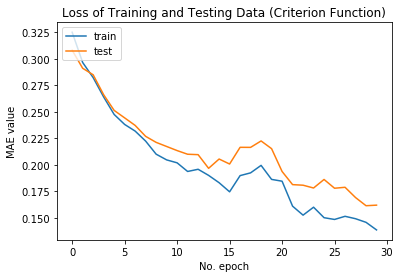

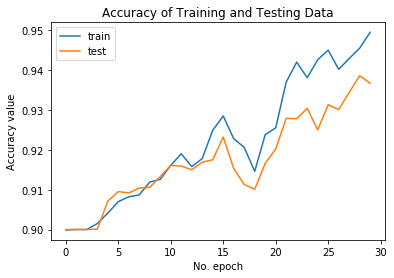

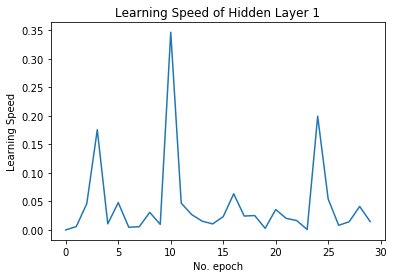

Training Accuracy - 0.9495
Training Loss - 0.1388147297501564
Testing Accuracy - 0.9367000460624695
Testing Loss - 0.16213250495493411


In [5]:
plot_model_result(history,weights,final_w)

## 2(b). Neural Network with 2 Hidden Layer and 3 Hidden Layer 

## 2 Hidden Layer without Regularization

In [6]:
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_dim=xtrain.shape[1]))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
weights1 = []
weights2 = []
save_weights1 = LambdaCallback(on_epoch_end=lambda batch, logs: weights1.append(model.layers[0].get_weights()[0]))
save_weights2 = LambdaCallback(on_epoch_end=lambda batch, logs: weights2.append(model.layers[1].get_weights()[0]))
sgd = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtrain, label_train,validation_data=(xtest, label_test), 
                    epochs=30, batch_size=10, shuffle = False,callbacks = [save_weights1,save_weights2])
final_w = [model.layers[0].get_weights()[0],model.layers[1].get_weights()[0]]
weights = [weights1,weights2]

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 1s 523us/step - loss: 0.3258 - accuracy: 0.9000 - val_loss: 0.3214 - val_accuracy: 0.9000
Epoch 2/30
1000/1000 [==============================] - 0s 327us/step - loss: 0.3157 - accuracy: 0.9000 - val_loss: 0.3153 - val_accuracy: 0.9000
Epoch 3/30
1000/1000 [==============================] - 0s 325us/step - loss: 0.3090 - accuracy: 0.9000 - val_loss: 0.3101 - val_accuracy: 0.9000
Epoch 4/30
1000/1000 [==============================] - 0s 326us/step - loss: 0.3043 - accuracy: 0.9000 - val_loss: 0.3056 - val_accuracy: 0.9000
Epoch 5/30
1000/1000 [==============================] - 0s 332us/step - loss: 0.2982 - accuracy: 0.9000 - val_loss: 0.3004 - val_accuracy: 0.9000
Epoch 6/30
1000/1000 [==============================] - 0s 328us/step - loss: 0.2922 - accuracy: 0.9000 - val_loss: 0.2953 - val_accuracy: 0.9000
Epoch 7/30
1000/1000 [==============================] - 0s 331us/step - loss

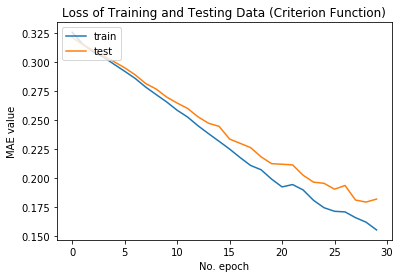

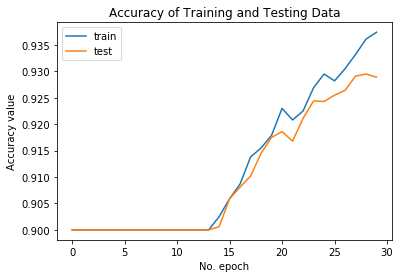

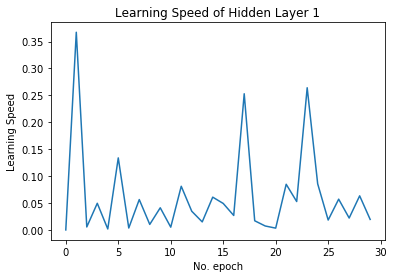

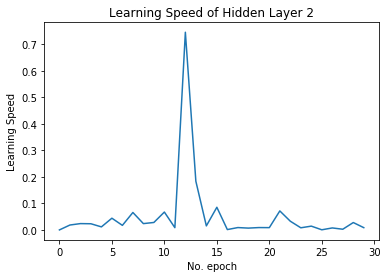

Training Accuracy - 0.9374001
Training Loss - 0.15553733289241792
Testing Accuracy - 0.9288999438285828
Testing Loss - 0.1820969170331955


In [7]:
plot_model_result(history,weights,final_w)

## 3 Hidden Layer Without Regularization

In [8]:
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_dim=xtrain.shape[1]))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
weights1 = []
weights2 = []
weights3 = []
save_weights1 = LambdaCallback(on_epoch_end=lambda batch, logs: weights1.append(model.layers[0].get_weights()[0]))
save_weights2 = LambdaCallback(on_epoch_end=lambda batch, logs: weights2.append(model.layers[1].get_weights()[0]))
save_weights3 = LambdaCallback(on_epoch_end=lambda batch, logs: weights3.append(model.layers[1].get_weights()[0]))
sgd = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtrain, label_train,validation_data=(xtest, label_test), 
                    epochs=30, batch_size=10, shuffle = False,callbacks = [save_weights1,save_weights2,save_weights3])
final_w = [model.layers[0].get_weights()[0],model.layers[1].get_weights()[0],model.layers[2].get_weights()[0]]
weights = [weights1,weights2,weights3]

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 1s 561us/step - loss: 0.3428 - accuracy: 0.9000 - val_loss: 0.3306 - val_accuracy: 0.9000
Epoch 2/30
1000/1000 [==============================] - 0s 339us/step - loss: 0.3274 - accuracy: 0.9000 - val_loss: 0.3247 - val_accuracy: 0.9000
Epoch 3/30
1000/1000 [==============================] - 0s 335us/step - loss: 0.3242 - accuracy: 0.9000 - val_loss: 0.3234 - val_accuracy: 0.9000
Epoch 4/30
1000/1000 [==============================] - 0s 341us/step - loss: 0.3231 - accuracy: 0.9000 - val_loss: 0.3231 - val_accuracy: 0.9000
Epoch 5/30
1000/1000 [==============================] - 0s 346us/step - loss: 0.3226 - accuracy: 0.9000 - val_loss: 0.3227 - val_accuracy: 0.9000
Epoch 6/30
1000/1000 [==============================] - 0s 340us/step - loss: 0.3220 - accuracy: 0.9000 - val_loss: 0.3221 - val_accuracy: 0.9000
Epoch 7/30
1000/1000 [==============================] - 0s 334us/step - loss

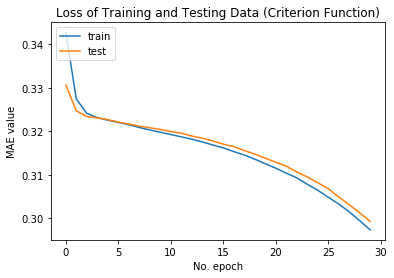

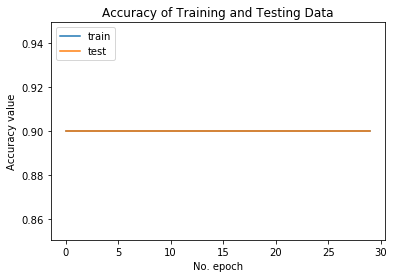

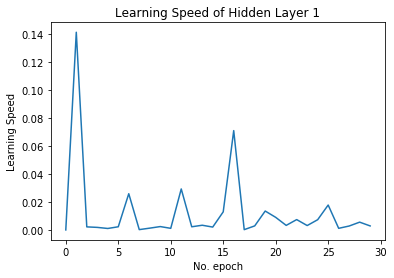

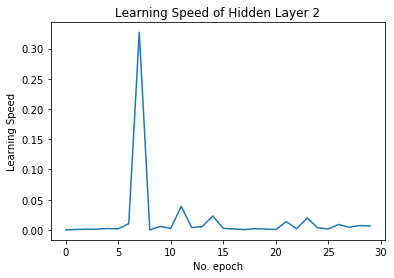

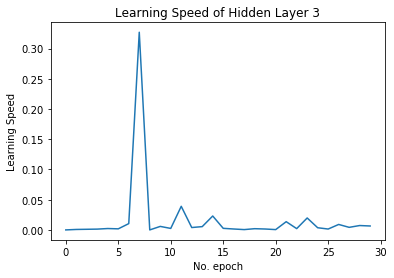

Training Accuracy - 0.9
Training Loss - 0.2972880381345749
Testing Accuracy - 0.8999999761581421
Testing Loss - 0.2992702731490135


In [9]:
plot_model_result(history,weights,final_w)

## 1 Hidden layer with Regularization - l2(5)

In [10]:
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_dim=xtrain.shape[1],
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
model.add(Dense(10, activation='softmax',
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
weights = []
save_weights = LambdaCallback(on_epoch_end=lambda batch, logs: weights.append(model.layers[0].get_weights()[0]))
sgd = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtrain, label_train,validation_data=(xtest, label_test), 
                    epochs=30, batch_size=10, shuffle = False,callbacks = [save_weights])
final_w = [model.layers[0].get_weights()[0]]
weights = [weights]

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 1s 567us/step - loss: 3.9812 - accuracy: 0.9000 - val_loss: 0.3253 - val_accuracy: 0.9000
Epoch 2/30
1000/1000 [==============================] - 0s 322us/step - loss: 0.3257 - accuracy: 0.9000 - val_loss: 0.3253 - val_accuracy: 0.9000
Epoch 3/30
1000/1000 [==============================] - 0s 321us/step - loss: 0.3257 - accuracy: 0.9000 - val_loss: 0.3253 - val_accuracy: 0.9000
Epoch 4/30
1000/1000 [==============================] - 0s 322us/step - loss: 0.3257 - accuracy: 0.9000 - val_loss: 0.3253 - val_accuracy: 0.9000
Epoch 5/30
1000/1000 [==============================] - 0s 323us/step - loss: 0.3257 - accuracy: 0.9000 - val_loss: 0.3253 - val_accuracy: 0.9000
Epoch 6/30
1000/1000 [==============================] - 0s 324us/step - loss: 0.3257 - accuracy: 0.9000 - val_loss: 0.3253 - val_accuracy: 0.9000
Epoch 7/30
1000/1000 [==============================] - 0s 324us/step - loss

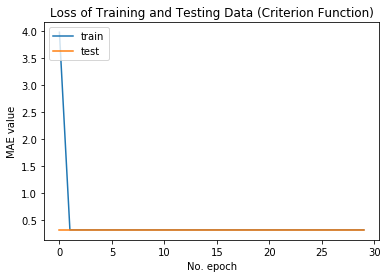

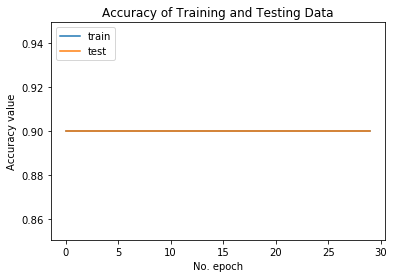

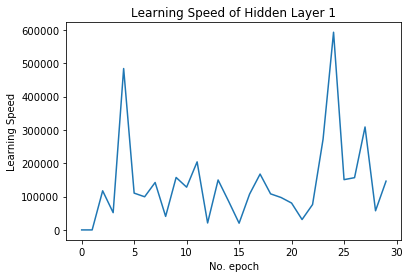

Training Accuracy - 0.9
Training Loss - 0.32565156906843185
Testing Accuracy - 0.8999999761581421
Testing Loss - 0.3252680179476738


In [11]:
plot_model_result(history,weights,final_w)

## 2 Hidden Layer with Regularization - l2(5)

In [12]:
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_dim=xtrain.shape[1],
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
model.add(Dense(30, activation='sigmoid',
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
model.add(Dense(10, activation='softmax',
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
weights1 = []
weights2 = []
save_weights1 = LambdaCallback(on_epoch_end=lambda batch, logs: weights1.append(model.layers[0].get_weights()[0]))
save_weights2 = LambdaCallback(on_epoch_end=lambda batch, logs: weights2.append(model.layers[1].get_weights()[0]))
sgd = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtrain, label_train,validation_data=(xtest, label_test), 
                    epochs=30, batch_size=10, shuffle = False,callbacks = [save_weights1,save_weights2])
final_w = [model.layers[0].get_weights()[0],model.layers[1].get_weights()[0]]
weights = [weights1,weights2]

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 1s 630us/step - loss: 5.4465 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 2/30
1000/1000 [==============================] - 0s 329us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 3/30
1000/1000 [==============================] - 0s 328us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 4/30
1000/1000 [==============================] - 0s 326us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 5/30
1000/1000 [==============================] - 0s 328us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 6/30
1000/1000 [==============================] - 0s 330us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 7/30
1000/1000 [==============================] - 0s 332us/step - loss

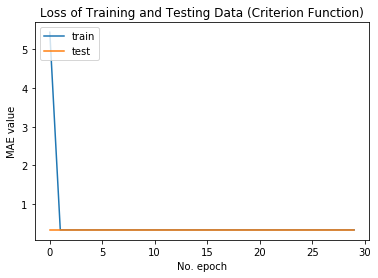

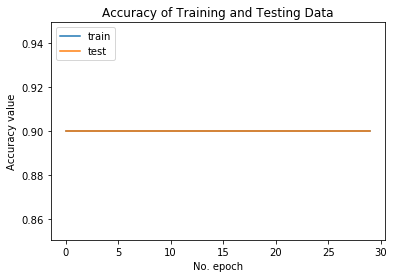

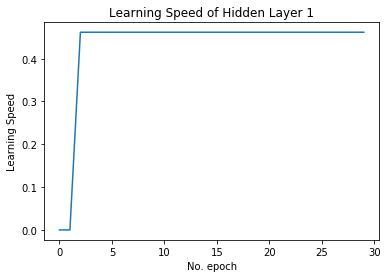

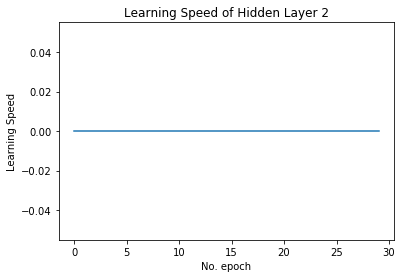

Training Accuracy - 0.9
Training Loss - 0.3255563199520111
Testing Accuracy - 0.8999999761581421
Testing Loss - 0.32548686414957045


In [13]:
plot_model_result(history,weights,final_w)

## 3 Hidden Layer with Regularization - l2(5)

In [14]:
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_dim=xtrain.shape[1],
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
model.add(Dense(30, activation='sigmoid',
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
model.add(Dense(30, activation='sigmoid',
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
model.add(Dense(10, activation='softmax',
                kernel_regularizer=regularizers.l2(5),
                bias_regularizer=regularizers.l2(5)))
weights1 = []
weights2 = []
weights3 = []
save_weights1 = LambdaCallback(on_epoch_end=lambda batch, logs: weights1.append(model.layers[0].get_weights()[0]))
save_weights2 = LambdaCallback(on_epoch_end=lambda batch, logs: weights2.append(model.layers[1].get_weights()[0]))
save_weights3 = LambdaCallback(on_epoch_end=lambda batch, logs: weights3.append(model.layers[1].get_weights()[0]))
sgd = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtrain, label_train,validation_data=(xtest, label_test), 
                    epochs=30, batch_size=10, shuffle = False,callbacks = [save_weights1,save_weights2,save_weights3])
final_w = [model.layers[0].get_weights()[0],model.layers[1].get_weights()[0],model.layers[2].get_weights()[0]]
weights = [weights1,weights2,weights3]

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 1s 695us/step - loss: 6.9392 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 2/30
1000/1000 [==============================] - 0s 355us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 3/30
1000/1000 [==============================] - 0s 355us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 4/30
1000/1000 [==============================] - 0s 356us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 5/30
1000/1000 [==============================] - 0s 357us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 6/30
1000/1000 [==============================] - 0s 352us/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 7/30
1000/1000 [==============================] - 0s 354us/step - loss

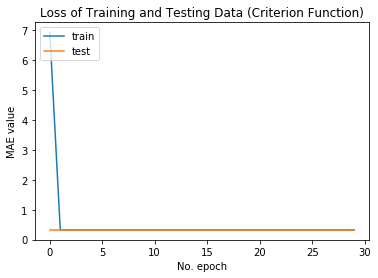

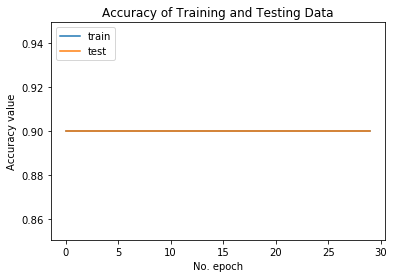

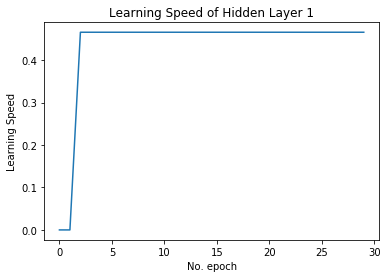

c:\users\moham\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


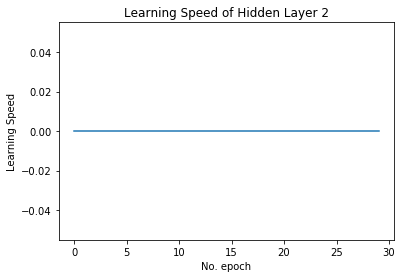

c:\users\moham\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


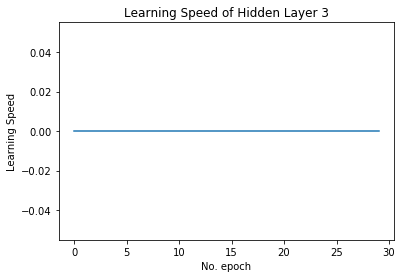

Training Accuracy - 0.9
Training Loss - 0.3255563199520111
Testing Accuracy - 0.8999999761581421
Testing Loss - 0.32548686414957045


In [15]:
plot_model_result(history,weights,final_w)

## 2(c) . Construct and Train Convolutional Neural network
For Convolutional Neural Networks we first change shape of th Datasets from set of array of 1 Dimensional array of $28x28$ image to a set of 3-Dimensinal Image with Value.

In [16]:
x_train_imgs = xtrain.reshape(xtrain.shape[0],28,28,1)
x_test_imgs = xtrain.reshape(xtest.shape[0],28,28,1)

### Preprocessing the Image :
We use th ImageDataGenerator library from keras to generate a augumented form of out original training dataset.

In [17]:
from keras.preprocessing.image import ImageDataGenerator
aug_data = ImageDataGenerator(rotation_range=3,
                              width_shift_range=0.25, # 0.25 * 28 = 8 pixels approx
                              height_shift_range=0.25, # 0.25 * 28 = 8 pixels approx
                              horizontal_flip=True,
                              fill_mode="nearest")
aug_data.fit(x_train_imgs)
n = 0
for x_batch, y_batch in aug_data.flow(x_train_imgs, label_train, batch_size=1000):
    x_batch = np.reshape(x_batch, [-1, 28*28])
    model.fit(x_batch, y_batch)
    n += 1
    if n >= len(x_train_imgs) / 1000:
        break
x_batch = x_batch.reshape(x_batch.shape[0],28,28,1)               

Epoch 1/1
1000/1000 [==============================] - 0s 78us/step - loss: 0.3252 - accuracy: 0.9000


Now we build the Convolutional Neutral Network and feed the Augumented Training Dataset to our model.

In [18]:
model = Sequential()
model.add(Conv2D(30, activation='sigmoid',kernel_size=(5, 5), input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
weights = []
save_weights = LambdaCallback(on_epoch_end=lambda batch, logs: weights.append(model.layers[0].get_weights()[0]))
sgd = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_batch, y_batch,validation_data=(x_test_imgs, label_test), 
                    epochs=30, batch_size=10, shuffle = False,callbacks = [save_weights])
final_w = [model.layers[0].get_weights()[0]]
weights = [weights]

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 1s 1ms/step - loss: 0.7134 - accuracy: 0.8686 - val_loss: 0.3678 - val_accuracy: 0.8987
Epoch 2/30
1000/1000 [==============================] - 1s 883us/step - loss: 0.3261 - accuracy: 0.8984 - val_loss: 0.3791 - val_accuracy: 0.8962
Epoch 3/30
1000/1000 [==============================] - 1s 874us/step - loss: 0.3104 - accuracy: 0.8997 - val_loss: 0.3911 - val_accuracy: 0.8927
Epoch 4/30
1000/1000 [==============================] - 1s 881us/step - loss: 0.2959 - accuracy: 0.9031 - val_loss: 0.3962 - val_accuracy: 0.8924
Epoch 5/30
1000/1000 [==============================] - 1s 880us/step - loss: 0.2871 - accuracy: 0.9046 - val_loss: 0.4069 - val_accuracy: 0.8873
Epoch 6/30
1000/1000 [==============================] - 1s 878us/step - loss: 0.2766 - accuracy: 0.9055 - val_loss: 0.4134 - val_accuracy: 0.8900
Epoch 7/30
1000/1000 [==============================] - 1s 871us/step - loss: 

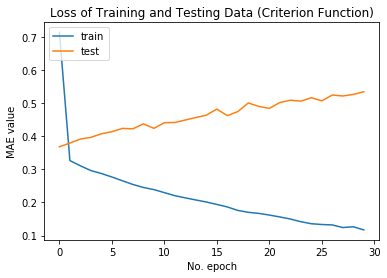

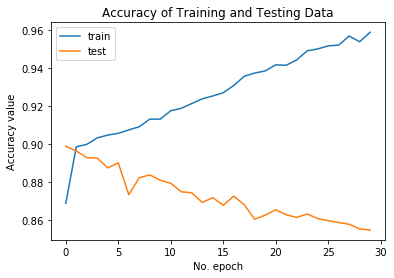

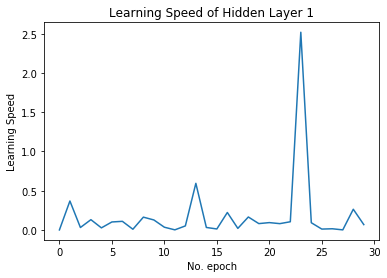

Training Accuracy - 0.95879996
Training Loss - 0.11689612984657288
Testing Accuracy - 0.8545998930931091
Testing Loss - 0.5339137265086173


In [19]:
plot_model_result(history,weights,final_w)